## Introduction

This notebook demonstrates how to load 
[US Census American Community Survey (ACS) Public-Use Microdata Samples](https://www.census.gov/data/developers/data-sets/census-microdata-api.ACS_5-Year_PUMS.html). The process is very much parallel to how we loaded and used
[US Census redistricting data](https://www.census.gov/programs-surveys/decennial-census/about/rdo.html)
in the 
[SoMa DIS Demo](https://github.com/vengroff/censusdis/blob/main/notebooks/SoMa%20DIS%20Demo.ipynb)
and 
[Seeing White](https://github.com/vengroff/censusdis/blob/main/notebooks/Seeing%20White.ipynb)
notebooks.

## Imports and configuration

In [1]:
import os
import os.path

import pandas as pd

import censusdis.data as ced
import censusdis.geography as cgeo
import censusdis.states
from censusdis.maps import ShapeReader, clip_to_states

import divintseg as dis

In [2]:
# Set your API key here.
CENSUS_API_KEY = None

In [3]:
YEAR = 2020
DATASET = "acs/acs5/pums"

In [4]:
STATE = censusdis.states.STATE_MA

## Query Metadata

First we will see what variables are avialable in the dataset.

In [5]:
group = ced.variables.get_group(DATASET, YEAR, None)

group.keys()

dict_keys(['for', 'in', 'ucgid', 'WKW', 'FBATHP', 'DRIVESP', 'WGTP23', 'WGTP22', 'WGTP25', 'WGTP24', 'RACNH', 'FWATP', 'WGTP21', 'WGTP20', 'WGTP27', 'WGTP26', 'WGTP29', 'WGTP28', 'FBROADBNDP', 'FDRATXP', 'FWKWNP', 'HOTWAT', 'FWKHP', 'FJWDP', 'WORKSTAT', 'FRACP', 'FFULP', 'WGTP34', 'WGTP33', 'WGTP36', 'PINCP', 'WGTP35', 'FPOBP', 'WGTP30', 'WGTP32', 'STOV', 'FMHP', 'WGTP31', 'RACAIAN', 'WGTP38', 'WGTP37', 'WGTP39', 'PUBCOV', 'SRNT', 'SEX', 'WGTP45', 'WGTP44', 'FACCESSP', 'WGTP47', 'DOUT', 'WGTP46', 'WGTP41', 'WGTP40', 'OTHSVCEX', 'WGTP43', 'RACPI', 'WGTP42', 'INDP', 'WGTP49', 'WGTP48', 'PRIVCOV', 'SFN', 'FINTP', 'HUPAC', 'SFR', 'WGTP50', 'FBLDP', 'WGTP56', 'WGTP55', 'WGTP58', 'WGTP57', 'WGTP52', 'WGTP51', 'DEAR', 'WGTP54', 'DIS', 'WGTP53', 'ACR', 'VACS', 'FINSP', 'WGTP59', 'FMILPP', 'MARHYP', 'ADJHSG', 'PAP', 'WGTP7', 'PWGTP30', 'WGTP6', 'PWGTP31', 'HINCP', 'WGTP5', 'PWGTP32', 'WKWN', 'WGTP4', 'PWGTP33', 'PWGTP34', 'PWGTP35', 'WGTP9', 'PWGTP36', 'WGTP8', 'WGTP3', 'WGTP2', 'RACWHT', 'WGTP

In [6]:
group["AGEP"]

{'label': 'Age',
 'predicateType': 'int',
 'group': 'N/A',
 'limit': 0,
 'suggested-weight': 'PWGTP',
 'values': {'item': {'0': 'Under 1 year'},
  'range': [{'min': '1',
    'max': '99',
    'description': '1 to 99 years (Top-coded)'}]},
 'name': 'AGEP'}

Next we will see what geographies are available. Note that PUMS data is available in a lot fewer
geography hierarchies than the full ACS5 data set.

In [7]:
cgeo.geo_path_snake_specs(DATASET, YEAR)

{'020': ['region'],
 '030': ['division'],
 '040': ['state'],
 '795': ['state', 'public_use_microdata_area']}

## Query Age and it's Suggested Weight at the PUMA Level

In [8]:
query_variables = ["AGEP"]

In [9]:
variable_weights = {
    variable: group[variable]["suggested-weight"] for variable in query_variables
}

unique_weights = list(set(variable_weights.values()))

In [10]:
df_acs5_pums = ced.download_detail(
    DATASET,
    YEAR,
    query_variables + unique_weights,
    state=STATE,
    public_use_microdata_area="*",
)

df_acs5_pums

,STATE,PUBLIC_USE_MICRODATA_AREA,AGEP,PWGTP
0,25,3900,46,14
1,25,3900,46,12
2,25,3900,12,13
3,25,302,52,14
4,25,302,21,17
...,...,...,...,...
335405,25,506,65,12
335406,25,4301,89,20
335407,25,400,51,5
335408,25,400,56,6


In [11]:
# Reformat and rename for easier merging with the map later.
df_acs5_pums["PUMACE"] = df_acs5_pums["PUBLIC_USE_MICRODATA_AREA"].apply(
    lambda p: f"{int(p):05d}"
)

## Compute Average Age in Each Area

In [12]:
df_average_age = (
    df_acs5_pums.groupby("PUMACE")
    .apply(
        lambda g: (g["AGEP"] * g[variable_weights["AGEP"]]).sum()
        / g[variable_weights["AGEP"]].sum()
    )
    .rename("avg_age")
    .reset_index()
)

## Load map data and merge in our PUMS data

In [13]:
SHAPEFILE_ROOT = os.path.join(os.environ["HOME"], "data", "shapefiles")

# Make sure it is there.
if not os.path.isdir(SHAPEFILE_ROOT):
    os.mkdir(SHAPEFILE_ROOT)

In [14]:
reader = ShapeReader(SHAPEFILE_ROOT, year=YEAR)

In [15]:
gdf_puma = reader.read_shapefile(STATE, "puma")

## Plot the Map

In [16]:
gdf_avg_age = gdf_puma.merge(df_average_age, left_on="PUMACE10", right_on="PUMACE")

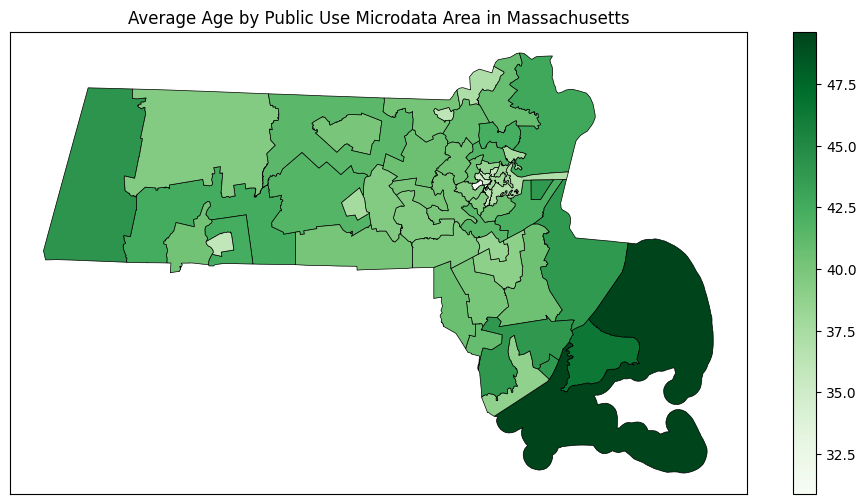

In [17]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

ax = gdf_avg_age.plot(
    "avg_age", cmap="Greens", edgecolor="black", legend=True, linewidth=0.5
)

ax.set_title(
    f"Average Age by Public Use Microdata Area in {censusdis.states.STATE_NAMES_FROM_IDS[STATE]}"
)

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)